# Forecasting company key numbers from public data

## Device configuration and import of libaries used

In [1]:
import requests
import json
import csv
import re
from datetime import datetime, timedelta
import os.path
import operator
import xml.etree.ElementTree as et
from dateutil.relativedelta import relativedelta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## CVR downloader

The dataset can be extracted initially by downloaded annual reports from various companies. The following script will download annual reports from each day and save it to a file. 

In [2]:
if not os.path.isfile('reports.csv'):
    now = datetime.now()
    date = datetime.strptime('2013-03-03', '%Y-%m-%d')

    with open('reports.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(['cvrNummer','annualReport'])
        while date < now:
            nextdate = (date + timedelta(days=1))

            if date.year < nextdate.year:
                print(nextdate.year)

            url = 'http://distribution.virk.dk/offentliggoerelser/_search'
            payload = '{"query": {"bool": {"must": [{"range": {"offentliggoerelsesTidspunkt": {"gt": "' + str(date.strftime('%Y-%m-%d')) + 'T00:00:00.001Z","lt": "' + str(nextdate.strftime('%Y-%m-%d')) + 'T23:59:59.505Z"}}},{"term": {"dokumenter.dokumentMimeType": "xml"}}]}},"sort": [{"regnskab.regnskabsperiode.startDato": {"order": "asc"}}],"size": 2999}'
            headers = {'Content-Type': 'application/json'}
            r = requests.post(url, data=payload, headers=headers)

            parsed_json = json.loads(r.content)

            for i in parsed_json['hits']['hits']:  
                for j in i['_source']['dokumenter']:
                    # This check may be redundant
                    if (re.search('.xml', j['dokumentUrl'])):
                        csvwriter.writerow([i['_source']['cvrNummer'],re.search(".xml",j['dokumentUrl']).string])
                        break

            # if (parsed_json['hits']['total'] > 2999):
                # print(parsed_json['hits']['total'])
            date = nextdate
            # if (parsed_json['hits']['total'] == 0):
                # print(parsed_json['hits']['total'])

## Crawling through the reports

As the previous retrieved dataset only contains the identifier of the company (CVR) and the URL for the annual reports, a crawler therefore needs to be used to extract the data from each anual reports and append it to a new file. This crawler sorts the entire file and extracts 21 key numbers from the reports of each company. If a year is omitted the entire history of the company is rendered useless and therefore skipped. This process is extremely slow.

In [3]:
# WARNING: slow crawler
if not os.path.isfile('data.csv'):
    data = csv.reader(open('reports.csv'), delimiter=',')
    next(data)

    keyFiguresInput = ['{http://xbrl.dcca.dk/gsd}ReportingPeriodStartDate','{http://xbrl.dcca.dk/fsa}Revenue','{http://xbrl.dcca.dk/fsa}CostOfSales','{http://xbrl.dcca.dk/fsa}ExternalExpenses','{http://xbrl.dcca.dk/fsa}AdministrativeExpenses','{http://xbrl.dcca.dk/fsa}GrossResult','{http://xbrl.dcca.dk/fsa}ProfitLossFromOrdinaryOperatingActivities','{http://xbrl.dcca.dk/fsa}ProfitLossFromOrdinaryActivitiesBeforeTax','{http://xbrl.dcca.dk/fsa}ProfitLoss','{http://xbrl.dcca.dk/fsa}OtherShorttermReceivables','{http://xbrl.dcca.dk/fsa}ShorttermReceivables','{http://xbrl.dcca.dk/fsa}CashAndCashEquivalents','{http://xbrl.dcca.dk/fsa}CurrentAssets','{http://xbrl.dcca.dk/fsa}Assets','{http://xbrl.dcca.dk/fsa}ContributedCapital','{http://xbrl.dcca.dk/fsa}OtherReserves','{http://xbrl.dcca.dk/fsa}RetainedEarnings','{http://xbrl.dcca.dk/fsa}Equity','{http://xbrl.dcca.dk/fsa}OtherShorttermPayables','{http://xbrl.dcca.dk/fsa}ShorttermLiabilitiesOtherThanProvisions','{http://xbrl.dcca.dk/fsa}LiabilitiesOtherThanProvisions','{http://xbrl.dcca.dk/fsa}LiabilitiesAndEquity']

    fieldnames = ['Revenue','CostOfSales','ExternalExpenses','AdministrativeExpenses','GrossResult','ProfitLossFromOrdinaryOperatingActivities','ProfitLossFromOrdinaryActivitiesBeforeTax','ProfitLoss','OtherShorttermReceivables','ShorttermReceivables','CashAndCashEquivalents','CurrentAssets','Assets','ContributedCapital','OtherReserves','RetainedEarnings','Equity','OtherShorttermPayables','ShorttermLiabilitiesOtherThanProvisions','LiabilitiesOtherThanProvisions','LiabilitiesAndEquity']

    reports = {}
    second = 0

    for i in data:
        if (second % 2 == 0):
            reports.setdefault(i[0], set([])).add(i[1])
        second = 1+second

    counter = 0

    csvwriter = csv.writer(open('data.csv', 'w', newline=''), delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for key in reports:
        if (counter > 0):
            reportcontents = []
            for report in reports[key]:
                root = et.fromstring(requests.get(report).content)
                reportcontent = [None] * len(keyFiguresInput)
                for child in root:
                    if child.tag in keyFiguresInput:
                        reportcontent[keyFiguresInput.index(child.tag)] = child.text
                reportcontents.append(reportcontent)
            sortedlist = sorted(reportcontents, key = lambda x: x[0])
            datechecker = iter(sortedlist)
            d1 = datetime.strptime(next(datechecker)[0], "%Y-%m-%d")
            include = True
            for report in datechecker:
                d2 = datetime.strptime(report[0], "%Y-%m-%d")
                if (relativedelta(d2, d1).years > 1):
                    include = False
                    break
                d1 = d2
            if include:
                csvwriter.writerow([item for sublist in sortedlist for item in sublist])
        counter = counter + 1
        if (counter % 500 == 0):
            print(counter)

    # with open('test.csv', 'w', newline='') as csvfile:
    #     csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    #     for report in reports:
    #         csvwriter.writerow(reduce(lambda x,y :x+y ,sorted(reports[report], key=lambda x: x[0])))    

## Data preparation

The dataset is not sorted by annual reports for each company saved in batches. Each batch needs normalization and identifiers for missing values as the missing values and 0 are used interchangeably. The steps are explained in the report. Initially the data should be shuffled as the previous dataset is sorted by CVR, which may have a hidden pattern that we don't want in our model.

In [4]:
! shuf -o shuffled_data.csv < data.csv

In [4]:
csv = csv.reader(open('shuffled_data.csv'), delimiter=',')

features = 16
# zeros = [0] * features
# total = 0

data = []
for i in csv:
    # Remove date as we don't want date to influence training
    # Also remove features with too much missing data
    for j in range(int(len(i)/22)):
        del i[(j*17)-j:((j*17)-j+5)]
        del i[(j*10)-j]
        # del i[(j*22)-j]
    # Append identifier list for missing data

    conv1 = lambda i: i != "" or False

    identifier = ([conv1(j) for j in i])

    # Convert list to list of integers
    conv2 = lambda i: i or 0
    i = [conv2(j) for j in i]
    i = list(map(float, i))

    # Convert 1d to 2d array with 22 columns
    i = [i[j:j+features] for j in range(0, len(i), features)]
    identifier = [identifier[j:j+features] for j in range(0, len(identifier), features)]

    # for x in i:
    #     total += 1
    #     for y in range(len(zeros)):
    #         if x[y] == 0.0:
    #             zeros[y] += 1

    dataset = np.asarray(i)

    # Remove too small data samples
    if (dataset.ndim == 1 or len(dataset) < 3):
        continue
    dataset = dataset[:,0:features]
    # Normalization
    dataset -= np.mean(dataset, axis = 0)
    # Division by zero is possible and results in nan values
    dataset /= np.std(dataset, axis = 0)
    # Previous nan values are removed
    dataset[np.isnan(dataset)] = 0.0

    # dataset = scaler.fit_transform(dataset)
    # dataset = (normalize_list(dataset.T)).T

    dataset = np.concatenate((dataset, np.asarray(identifier)), axis=1)

    data.append(dataset)
    
training = data[:int(len(data)*0.8)]
validation = data[-int(len(data)*0.2):-int(len(data)*0.1)]
testing = data[-int(len(data)*0.1):]

print(len(training))
print(len(validation))
print(len(testing))

<ipython-input-4-41f567f3a647>:45: RuntimeWarning: invalid value encountered in true_divide
  dataset /= np.std(dataset, axis = 0)


52525
6566
6565


In [14]:
in_features = features*2
hidden_dim = 128
out_features = features*2
n_layers = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm = nn.LSTM(in_features, hidden_dim, num_layers = n_layers, batch_first = True)
        # self.gru = nn.GRU(in_features, hidden_dim, num_layers = n_layers, batch_first = True)
        self.l_out = nn.Linear(in_features = hidden_dim, out_features = out_features, bias = False)

    def forward(self, x):
        h0 = torch.zeros(n_layers, x.size(0), hidden_dim).to(device) 
        c0 = torch.zeros(n_layers, x.size(0), hidden_dim).to(device)
        # print(x.shape)
        x, _ = self.lstm(x, (h0, c0))
        # x, _ = self.gru(x, h0)
        # print(x.shape)
        x = self.l_out(x[-1,:,:])
        # x = x.reshape(self.l_out.out_features, -1)
        # print(x.shape)
        return x[-1]

net = Net().to(device)
print(net)

Net(
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True)
  (l_out): Linear(in_features=128, out_features=32, bias=False)
)


## Training and validation

The model is trained with Mean Square Error Loss as we're dealing with regression, few features and the numerical difference between the values are small due to normalization. Additionally the accuracy is included with a threshold of both 5 % and 10 % to show how well it is predicting. 

In [15]:
num_epochs = 100
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.05, momentum = 0.8, weight_decay = 1e-5)

training_loss, validation_loss, accuracy1, accuracy2 = [], [], [], []
# Theshold for accuracy at around the market rate
threshold1 = 0.05
threshold2 = 0.10

for i in range(num_epochs):

    epoch_training_loss = 0
    epoch_validation_loss = 0
    total_num_corrects1 = 0
    total_num_corrects2 = 0

    np.random.shuffle(validation)
    np.random.shuffle(training)
    
    net.eval()
    
    for batch in validation:
        target = batch[-1,:]
        inputs = batch[:-1,:]

        inputs = torch.Tensor(inputs).to(device)
        inputs = inputs.reshape(inputs.size(0), 1, in_features)
        target = torch.Tensor(target).to(device)

        outputs = net(inputs)
        loss = criterion(outputs, target)
        
        epoch_validation_loss += loss.detach().numpy()

        pred = (((outputs - target) >= -threshold1) & ((outputs - target) <= threshold1)).view_as(target)  # to make pred have same shape as target
        num_correct = torch.sum(pred).item()
        total_num_corrects1 += num_correct
        pred = (((outputs - target) >= -threshold2) & ((outputs - target) <= threshold2)).view_as(target)  # to make pred have same shape as target
        num_correct = torch.sum(pred).item()
        total_num_corrects2 += num_correct

    net.train()
    
    for batch in training:
        target = batch[-1,:]
        inputs = batch[:-1,:]

        inputs = torch.Tensor(inputs).to(device)
        inputs = inputs.reshape(inputs.size(0), 1, in_features)
        target = torch.Tensor(target).to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training))
    validation_loss.append(epoch_validation_loss/len(validation))

    # Save accuracy for plot
    accuracy1.append(total_num_corrects1/len(testing))
    accuracy2.append(total_num_corrects2/len(testing))

    # Print loss every 5 epochs
    if i % 1 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]:.5f}, validation loss: {validation_loss[-1]:.5f}, 0.05 accuracy: {accuracy1[-1]:.2f}, 0.10 accuracy: {accuracy2[-1]:.2f}')

torch.save(net.state_dict(), 'test.pt')

KeyboardInterrupt: 

## Testing

Finally the model is tested and graphs are printed to show how well the model performed during training

In [7]:
torch.load('test.pt')
threshold1 = 0.05
threshold2 = 0.10

net.eval()

total_num_corrects1 = 0
total_num_corrects2 = 0
correct1, correct2 = [], []

for batch in testing:
    target = batch[-1, :]
    inputs = batch[:-1, :]

    # Convert inputs to tensor
    inputs = torch.Tensor(inputs).to(device)
    inputs = inputs.reshape(inputs.size(0), 1, in_features)

    # Convert target to tensor
    target = torch.Tensor(target).to(device)

    # Forward pass
    outputs = net.forward(inputs)
    
    # Prediction is compared to a threshold as 100 % accuracy is not needed
    pred = (((outputs - target) >= -threshold1) & ((outputs - target) <= threshold1)).view_as(target)  # to make pred have same shape as target
    num_correct = torch.sum(pred).item()
    total_num_corrects1 += num_correct
    correct1.append(num_correct)
    pred = (((outputs - target) >= -threshold2) & ((outputs - target) <= threshold2)).view_as(target)  # to make pred have same shape as target
    num_correct = torch.sum(pred).item()
    total_num_corrects2 += num_correct
    correct2.append(num_correct)

print(f'Test 0.05 accuracy is {total_num_corrects1/len(testing):.3f}')
print(f'Test 0.10 accuracy is {total_num_corrects2/len(testing):.3f}')

Test 0.05 accuracy is 12.973
Test 0.10 accuracy is 16.630


In [8]:
test = testing[0]

target = batch[-1, :]
inputs = batch[:-1, :]

inputs = torch.Tensor(inputs)
inputs = inputs.reshape(inputs.size(0), 1, in_features)

target = torch.Tensor(target)

output = net.forward(inputs)

print('\nInput years:')
print(inputs.data.numpy())
print('\nTarget year:')
print(target.data.numpy())
print('\nOutput year:')
print(output.data.numpy())


Input years:
[[[-0.4576048  -0.70710677 -1.0160723   0.          0.
   -0.70710677 -1.156441   -0.6688246   0.70710677 -0.70710677
   -0.4334531  -0.70710677  0.70710677 -0.70710677  0.70710677
   -0.70710677  1.          1.          1.          0.
    0.          0.          0.          1.          1.
    1.          1.          1.          1.          1.
    1.          0.        ]]

 [[ 1.387659   -0.70710677 -0.3438429   0.          0.
   -0.70710677  1.2831908  -0.74471015 -1.4142135  -0.70710677
    1.3825262  -0.70710677  0.70710677 -0.70710677  0.70710677
   -0.70710677  0.          1.          0.          0.
    1.          1.          1.          1.          0.
    1.          1.          1.          1.          1.
    1.          0.        ]]]

Target year:
[-0.9300541   1.4142135   1.3599151   0.          0.          1.4142135
 -0.12674978  1.4135348   0.70710677  1.4142135  -0.9490731   1.4142135
 -1.4142135   1.4142135  -1.4142135   1.4142135   1.          1.
  1.       

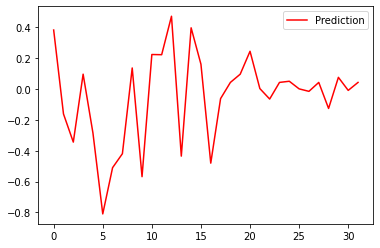

In [9]:
plt.figure()
plt.plot((output - target).data, 'r', label='Prediction')
plt.legend()
plt.show()

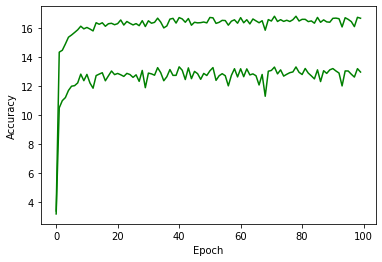

In [10]:
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, accuracy1, 'g', label='Accuracy',)
plt.plot(epoch, accuracy2, 'g', label='Accuracy',)
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.show()

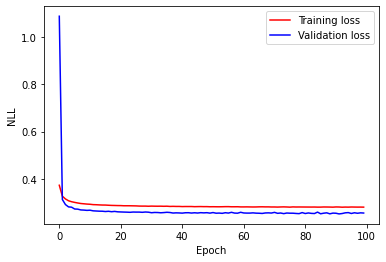

In [11]:
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Optional predictor given model

Sample of code to predict any given sequence of key numbers from annual reports that saves normalization such that the output can be transformed by using the mean and standard deviation used in normalization. The code is standalone and only requires the model saved. Change the variable 'x' with a new sequence and the model will predict the absolute values of the predicted next year. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import csv
import torch.optim as optim
np.set_printoptions(suppress=True,formatter={'float_kind':'{:0.2f}'.format})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = 16

x = [[ 1.680910e+05,0.000000e+00,1.251800e+05,2.064000e+04,3.419870e+05, 4.288100e+04,3.848680e+05,3.991820e+05,1.250000e+05, -1.138000e+03, 1.238620e+05,1.258160e+05,2.753200e+05,2.753200e+05,3.991820e+05, 0.000000e+00], [ 1.930280e+05,0.000000e+00,1.144320e+05,5.177230e+05,1.261570e+05, 6.730550e+05,6.755550e+05,1.250000e+05,0.000000e+00,1.390540e+05, 2.640540e+05,1.788260e+05,4.115010e+05,4.115010e+05,6.755550e+05, 0.000000e+00], [ 3.017540e+05,0.000000e+00,1.625940e+05,0.000000e+00,7.788220e+05, 4.957000e+05,1.303989e+06,1.413910e+06,1.250000e+05,0.000000e+00, 3.016490e+05,4.266490e+05,3.536870e+05,9.859640e+05,9.859640e+05, 1.413910e+06]]

def conv(x):
    conv1 = lambda i: i != 0 or False

    identifier = []
    for i in x:
        identifier.append([conv1(j) for j in i])

    x = np.asarray(x)

    mean = np.mean(x, axis = 0)
    std = np.std(x, axis = 0)

    x -= np.mean(x, axis = 0)
    x /= np.std(x, axis = 0)
    x[np.isnan(x)] = 0.0

    x = np.concatenate((x, np.asarray(identifier)), axis=1)

    return x, mean, std

in_features = features*2
hidden_dim = 50
out_features = features*2
n_layers = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm = nn.LSTM(in_features, hidden_dim, num_layers = n_layers, batch_first = True)
        # self.gru = nn.GRU(in_features, hidden_dim, num_layers = n_layers, batch_first = True)
        self.l_out = nn.Linear(in_features = hidden_dim, out_features = out_features, bias = False)        

    def forward(self, x):
        h0 = torch.zeros(n_layers, 1, hidden_dim).to(device)
        c0 = torch.zeros(n_layers, 1, hidden_dim).to(device)
        x, _ = self.lstm(x, (h0,c0))
        # x, _ = self.gru(x, h0)
        x = x.view(-1, hidden_dim)
        x = self.l_out(x)
        return x[-1]

net = Net().to(device)

net.load_state_dict(torch.load('model.pt', map_location='cpu'))

net.eval()

X, mean, std = conv(x)

target = X[-1, :]
inputs = X[:-1, :]

inputs = torch.Tensor(inputs)
inputs = inputs.reshape(1, inputs.size(0), in_features)

target = torch.Tensor(target)

outputs = net.forward(inputs)

print((outputs.detach().cpu().numpy()[:16] * std) + mean)